# 📞 Прогнозирование подписки клиента на банковский депозит

В проекте решается задача **бинарной классификации** — определить, согласится ли клиент оформить **годовой депозит** после маркетингового звонка.  
Данные включают социально-демографические признаки, информацию о трудоустройстве, наличие кредитов, историю взаимодействий банка с клиентом, а также макроэкономические показатели.

В рамках ноутбука будут выполнены:

- первичное исследование данных (EDA);
- обработка пропусков и выбросов;
- кодирование категориальных признаков;
- масштабирование данных (при необходимости);
- обучение нескольких моделей (логистическая регрессия, случайный лес, градиентный бустинг и др.);
- подбор гиперпараметров;
- оценка качества моделей с использованием:
  - **Accuracy**
  - **ROC-AUC**
  - **Precision / Recall**
  - **F1-score**

Проект направлен на поиск модели, способной эффективно предсказывать вероятность оформления депозита и помогающей банку оптимизировать маркетинговые кампании.

In [1846]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
import optuna

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

**Данные о клиентах банка:**

* age (возраст);

* job (сфера занятости);

* marital (семейное положение);

* education (уровень образования);

* default (имеется ли просроченный кредит);

* housing (имеется ли кредит на жильё);

* loan (имеется ли кредит на личные нужды);

* balance (баланс).

**Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:**

* contact (тип контакта с клиентом);

* month (месяц, в котором был последний контакт);

* day (день, в который был последний контакт);

* duration (продолжительность контакта в секундах).

**Прочие признаки:**

* campaign (количество контактов с этим клиентом в течение текущей кампании);

* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);

* previous (количество контактов до текущей кампании)

* poutcome (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

### Задание 1

In [1748]:
df = pd.read_csv('~/Desktop/Skillfactory/python_ml/PROJECT-4. Classification/data/bank_fin.csv', sep = ';')

Посмотрим на нашу таблицу и ее размерность

In [1749]:
display(df.head())
df.shape

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


(11162, 17)

Итак, у нас 11162 наблюдений(-я) и 17 признаков

Посмотрим на тип данных столбцов

In [1750]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


В нашей таблице 11 признаков типа "object" и 6 признаков типа "int"

In [1751]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

В признаке "balance" у нас 25 пропусков. Остальыне столбцы могут содержать неявные пропуски, которые будут мешать анализу

### Задание 2

In [1752]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

В признаке "job" у нас 70 неянвых пропусков которые обозначены как "unknown"

### Задание 3

In [1753]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
# Создадим функию, которая будет преобразовывать строку из признака balance в тип данных float
def balance_to_float(row):
    """
    Преобразует строковое представление денежного значения в число типа float.

    Очищает строку от символов валюты ($), пробелов и заменяет запятые на точки,
    чтобы корректно преобразовать в число. Если входное значение уже является числом
    или пропуском (NaN), возвращает его без изменений.

    Параметры:
    row : str, float, int или NaN
        Входное значение для преобразования. Может быть:
        - Строкой с денежным значением (например "1 000,50 $")
        - Числом (int или float)
        - Пропущенным значением (NaN)

    Возвращает:
    float или исходное значение:
        - Преобразованное число типа float, если ввод был строкой
        - Исходное число, если ввод был int/float
        - NaN, если ввод был пропуском
    """
    
    # Если пропуск или уже флоат/инт - то возвращаем значение
    if pd.isna(row) or isinstance(row, (float, int)):
        return row
    # Преобразуем строку во флоат со всеми преобразованиями
    row_float = row.strip().replace('$','').replace(',', '.').replace(' ', '')
    
    #Возвращаем число
    return float(row_float)

# Применим нашу функцию к столбцу balance
df['balance'] = df['balance'].apply(balance_to_float).astype(float)
df['balance'].mean().round(3)

np.float64(1529.129)

### Задание 4

In [1754]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df['balance'] = df['balance'].fillna(df['balance'].median())
df['balance'].mean().round(3)

np.float64(1526.936)

### Задание 5

In [1755]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
# Заменим пропуски в признаке job
df['job'] = df['job'].replace('unknown', df['job'].mode()[0])
# Заменим пропуски в признаке education
df['education'] = df['education'].replace('unknown', df['education'].mode()[0])

# Найдем модальное значения job
job_mode = df['job'].mode()[0]
# Найдем модальное значения education
education_mode = df['education'].mode()[0]
# Считаем средний баланс для моды в признаке job и education
mean_balance = df[(df['job'] == job_mode) & (df['education'] == education_mode)]['balance'].mean().round(3)

print(f'Средний баланс: {mean_balance}')

Средний баланс: 1598.883


### Задание 6

Text(0.5, 1.0, 'Balance Boxplot')

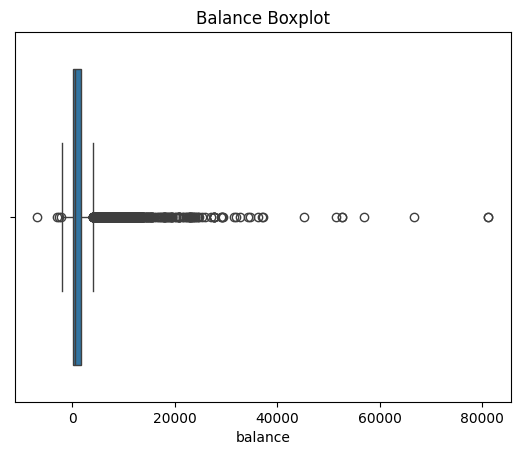

In [1756]:
# удалите все выбросы для признака balance
# ваш код
# Посмотрим на боксплот balance
sns.boxplot(x=df['balance'], )
# Название графика
plt.title('Balance Boxplot')

На графике можно заметить выбросы в виде жирного хвоста

Для поиска выбросов будем использовать метод Тьюки

In [1757]:
def find_outliers(data, feature, log_scale=False, left=1.5, right=1.5):
    """
    Находит выбросы по методу IQR с возможностью логарифмирования.
    
    Параметры:
    - data: DataFrame с данными.
    - feature: имя столбца для анализа.
    - log_scale: логарифмировать данные (bool).
    - left, right: множители для IQR (границы выбросов).
    
    Возвращает:
    - lower_bound, upper_bound: границы выбросов.
    - outliers: DataFrame с выбросами.
    - cleaned: DataFrame без выбросов.
    """
    
    # Если log_scale=True -> логарифмируем признак
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    
    # Находим первый квартиль
    q1 = x.quantile(0.25)
    # Находим третий квартиль 
    q3 = x.quantile(0.75)
    # Находим межквартильный размах
    iqr = q3 - q1
    
    # находим нижнюю границу
    lower_bound = q1 - (iqr * left)
    upper_bound = q3 + (iqr * right)
    
    # Находим выбросы 
    outliers = df[(x < lower_bound) | (x > upper_bound)]
    # Остальные данные
    cleaned = df[(x >= lower_bound) & (x <= upper_bound)]
    
    return lower_bound, upper_bound, outliers, cleaned
    
lower, upper, outliers, cleaned = find_outliers(df, 'balance', )

print(f'Нижняя граница: {round(lower)}')
print(f'Верхняя граница: {round(upper)}')
print(f'Кoл-во выбросов: {outliers.shape[0]}')

Нижняя граница: -2241
Верхняя граница: 4063
Кoл-во выбросов: 1057


Удалим выбросы

In [1758]:
# Копируем наш датафрейм в переменную df_cleaned
df_cleaned = cleaned.copy()

df_cleaned.shape[0]

10105

## Часть 2:  Разведывательный анализ

### Задание 1

In [1759]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
df_cleaned['deposit'].value_counts()

deposit
no     5424
yes    4681
Name: count, dtype: int64

Text(0.5, 1.0, 'Yes/No Ratio Distribution')

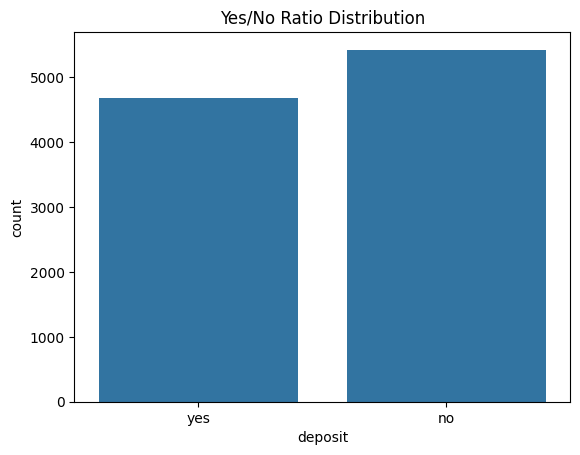

In [1760]:
# Визуализируем
sns.countplot(x=df_cleaned['deposit'])
# Название графика
plt.title('Yes/No Ratio Distribution')

Классы можно считать сбалансированными, соотношение почти 50/50

### Задания 2 и 3

In [1761]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
df_cleaned.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


- age: Показатели переменной Age находятся в пределах от 18 до 95 лет, что выглядит реалистично. Среднее значение возраста близко к медианному, что указывает на отсутствие сильной асимметрии распределения и выбросов. Стандартное отклонение, равное 11, свидетельствует о достаточно выраженной вариативности возрастных значений в выборке.

- balance: Баланс варьируется от -2049 до 4063, при этом медиана (445) существенно меньше среднего (≈807.7), что указывает на правостороннюю асимметрию и наличие выбросов. Также отрицательные значения баланса говорят о наличии клиентов с задолженностью.

- day: Среднее значение (15.6) и медиана (15) близки, что говорит об отсутствии перекоса в распределении.
Небольшое стандартное отклонение (8.4) говорит о похожим на равномерное распределение контактов по дням месяца.

- duration: Продолжительность контакта варьируется от 2 до 3881 секунд, медиана — 252, а среднее — ≈368.7.
Такое соотношение свидетельствует о асимметрии вправо. Стандартное отклонение (346.7) почти как само среднее, что указывает на сильную вариативность продолжительности контактов.

- campaign: Число контактов колеблется от 1 до 43, но медиана — всего 2, а среднее — 2.5. Это говорит о сильно скошенном распределении, большинство клиентов контактировали 1–2 раза, но есть редкие случаи с большим количеством контактов. Большой размах и стандартное отклонение (2.7) подтверждают наличие выбросов

- pdays: Минимальное значение — -1, которое, вероятно, обозначает отсутствие контакта в предыдущей кампании.Медиана и 25%/75% квартиль равны -1, тогда как максимум — 854 и среднее — 51.3. Это говорит о том, что большинство клиентов ранее не контактировали, но есть немногочисленные случаи с очень давними взаимодействиями — отсюда и очень сильная асимметрия. Стандартное отклонение (109.6) большое из-за этих редких случаев.

- previous: Значения варьируются от 0 до 58, при этом 50% клиентов не имели предыдущих контактов (медиана = 0). Среднее (≈0.82) и большое стандартное отклонение (≈2.24) указывают на то, что распределение сильно скошено вправо, с немногочисленными клиентами, контактировавшими многократно.Это типичный случай разреженных данных.

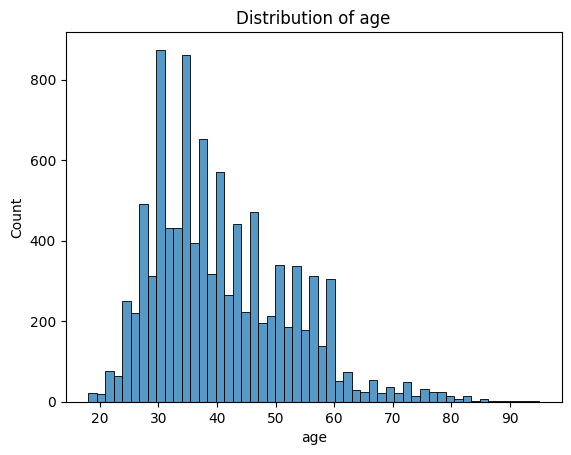

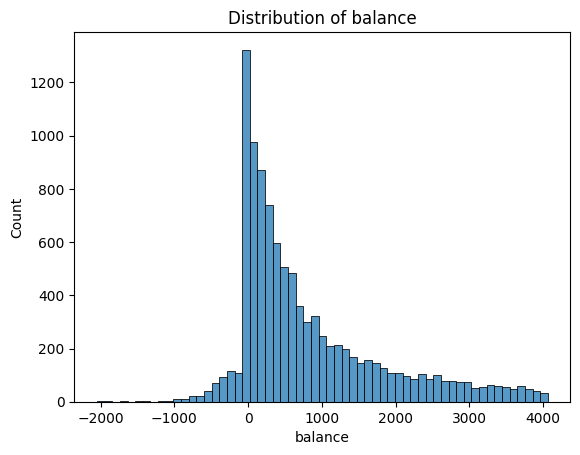

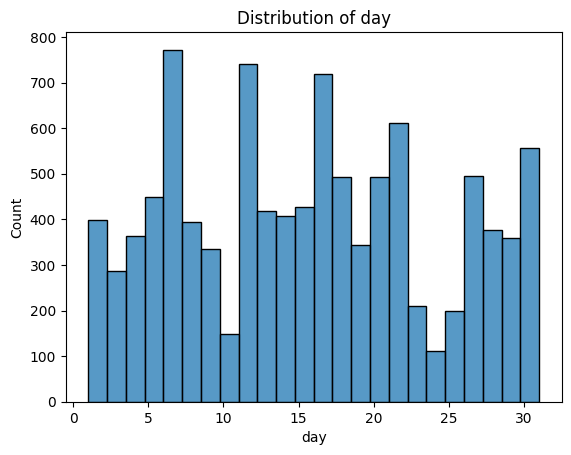

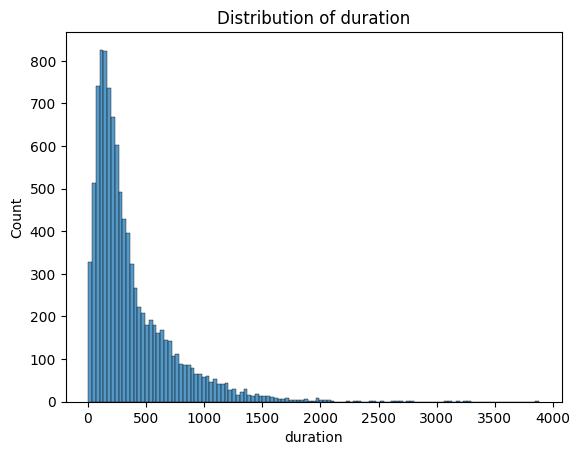

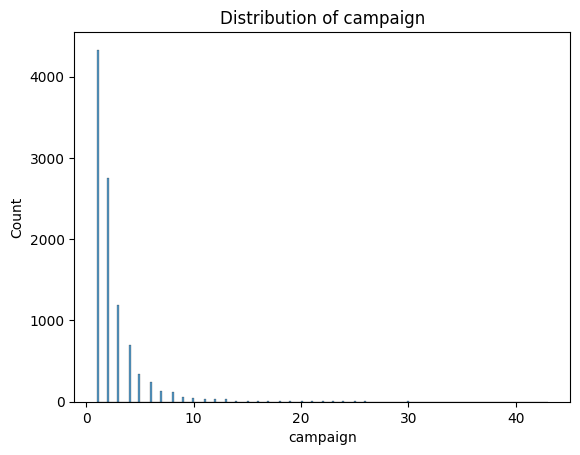

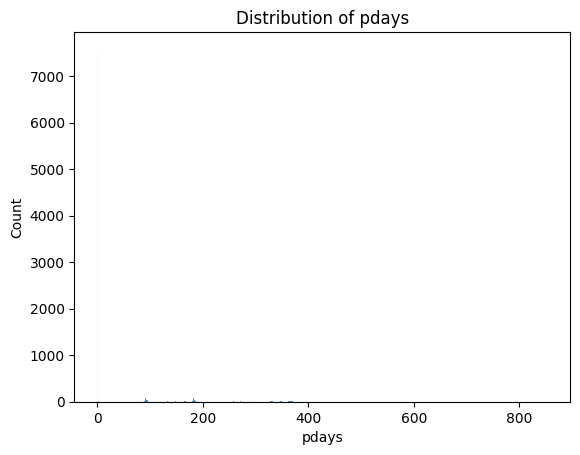

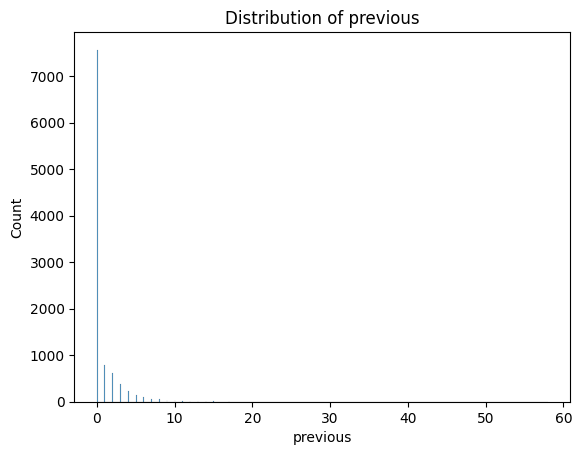

In [1762]:
# Выбираем только числовые колонки
num_cols = df_cleaned.select_dtypes(include=['number']).columns

# Строим все гистограммы в цикле 
for col in num_cols:
    sns.histplot(df_cleaned[col])
    plt.title(f'Distribution of {col}')
    plt.show()

**Вывод:** Распределение длительности контакта(duration), кол-во контактов в течение текущей компании(campaign), pdays и previous имеют правостороннюю асимметрию и жирный хвост, что свидетельствует о наличии данных, значительно превышающих среднее значение(и которые мы будем проверять на предмет выбросов).

Посмотрим на диаграмму рассеяния возраста и баланса в разрезе нашей целевой переменной

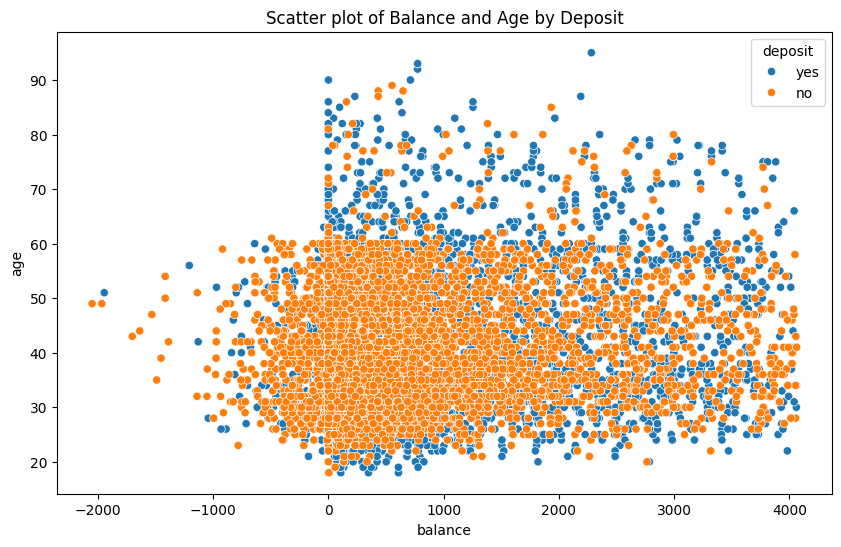

In [1763]:
# Инициализируем фигуру для графика
fig = plt.figure(figsize=(10, 6))
# Строим диаграмму рассеяния
sns.scatterplot(data=df_cleaned, x='balance', y='age', hue='deposit')
# Название графика
plt.title('Scatter plot of Balance and Age by Deposit')
# Показываем график
fig.show()

**Вывод по диаграмме:** Первое, что хочется отметить, это то, что большинство клиентов имеют баланс от 0 до 2000, и находятся в возрастной группе от 25 до 60 лет. Также отчетливо видно, что в старших возрастных группах намного чаще говорят "да" независимо от баланса. При низком или отрицательном балансе намного чаще встречается отказ. Ну и соответственно, клиенты с более высоким балансом чаще соглашаются на открытие депозита. 

Рассмотрим на распределение баланса в разрезе целевой переменной 

Text(0.5, 1.0, 'Boxplot of Balance by Deposit')

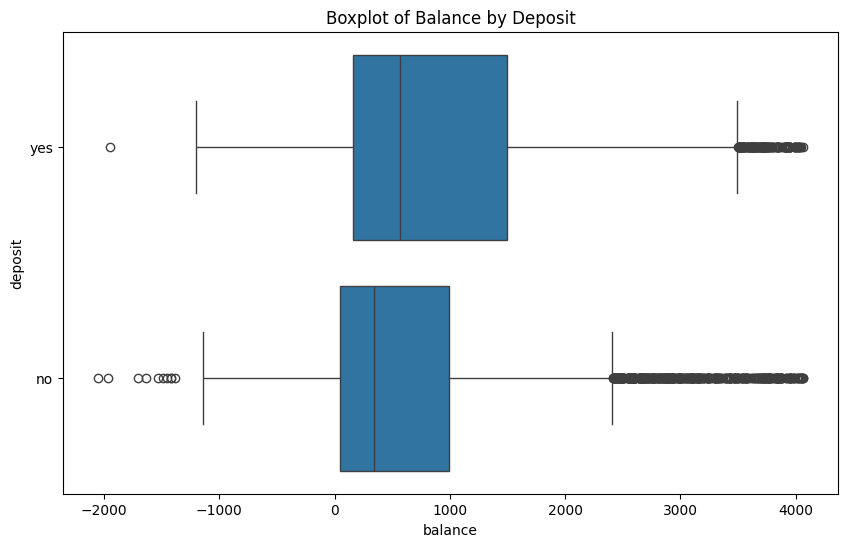

In [1764]:
# Инициализируем фигуру для графика
fig = plt.figure(figsize=(10, 6))
# Строим боксплот баланса в разрезе целевой переменной
sns.boxplot(data=df_cleaned, x='balance', y='deposit')
# Название графика
plt.title('Boxplot of Balance by Deposit')

**Вывод по диаграмме:** Видно, что медианный баланс у тех, кто согласился на депозит (группа “yes”), заметно выше, чем у тех, кто отказался (“no”). Также у клиентов, согласившихся на депозит, наблюдается больший разброс значений: верхний квартиль и усы диаграммы уходят дальше, что говорит о наличии клиентов с очень высокими балансами. В то же время в обеих группах есть выбросы, особенно в отрицательной области баланса, что указывает на наличие клиентов с задолженностью. В целом график подтверждает, что клиенты с более высоким балансом чаще склонны соглашаться на депозит.

Посмотрим на то, влияет ли время сессии звонка на открытие депозита

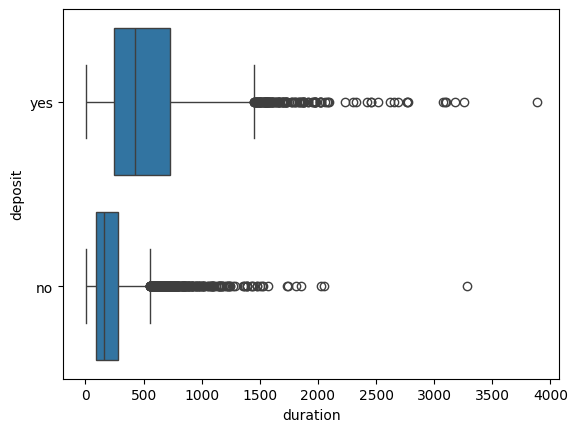

In [1765]:
# Строим боксплот
sns.boxplot(data=df_cleaned, x='duration', y='deposit')
plt.show()

**Вывод по графику:** На графике видно, что медиана длительности звонка значительно выше у клиентов, которые открыли депозит. Это может указывать на то, что более продолжительные звонки чаще связаны с заинтересованностью клиента. Также у этой группы наблюдается больший разброс значений, что говорит о наличии как коротких, так и очень длинных звонков. Выбросы присутствуют в обеих группах.

### Задания 4 и 5

In [1766]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
df_cleaned.describe(include=['object'])

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


- job: В данных представлено 11 уникальных категорий профессий. Наиболее часто встречающаяся — management (руководители), что подтверждается частотой 2315.

- marital: Переменная содержит 3 уникальных значения, чаще всего встречается категория married (женат/замужем), встречающаяся в 5715 случаях. Это указывает на преобладание семейных клиентов в выборке.

- education: Всего 3 уровня образования, наиболее распространённое — secondary (среднее образование), встречается у 5517 клиентов. Это указывает, что основная масса  имеет среднее образование

- default: Только 2 уникальных значения: yes и no. Значение no преобладает (9939 случаев), что говорит о том, что подавляющее большинство клиентов не имеют дефолта в кредитной истории.

- housing: Также представлено 2 значения, и чаще всего встречается no (5243 клиента не имеют ипотеки). Это означает, что более половины клиентов не имеют текущего ипотечного кредита.

- loan: Всего 2 значения, и опять доминирует no (8712 клиентов без потребительского кредита). То есть только небольшая часть выборки имеет активный потребительский заём.

- contact: Представлены 3 канала связи, и наиболее распространённый — cellular (мобильная связь), встречается в 7283 случаях.

- month: Переменная включает 12 уникальных значений, наиболее частым месяцем является May (май) с 2617 контактами. Это может свидетельствовать о сезонной активности кампании в мае.

- poutcome: Содержит 4 категории, при этом unknown (неизвестно) встречается в 7570 случаях. Это говорит о том, что результат предыдущей кампании в большинстве случаев либо не зафиксирован, либо клиент не участвовал в ней.

- deposit:  целевая переменная содержит 2 значения — yes и no. Большинство клиентов отказались от депозита (5424 “no”). Это значит, что больше половины клиентов не открыли депозит после контакта

Посмотрим на распределение категориальных признаков

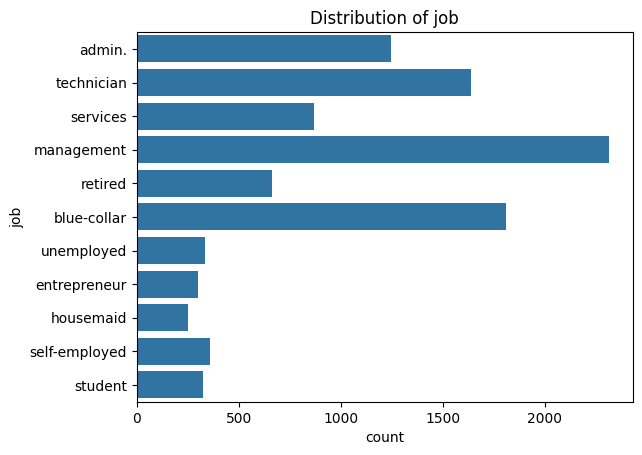

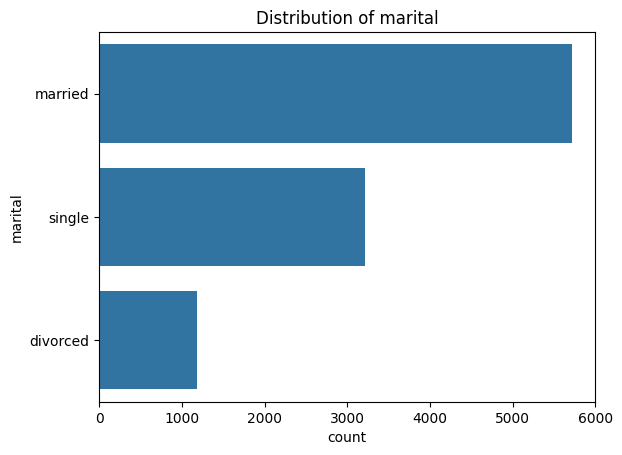

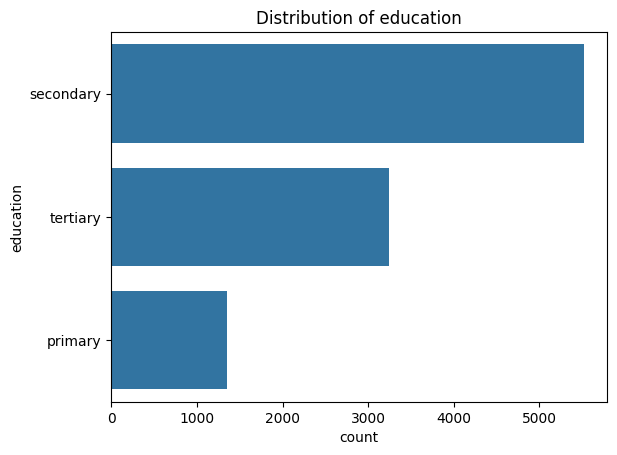

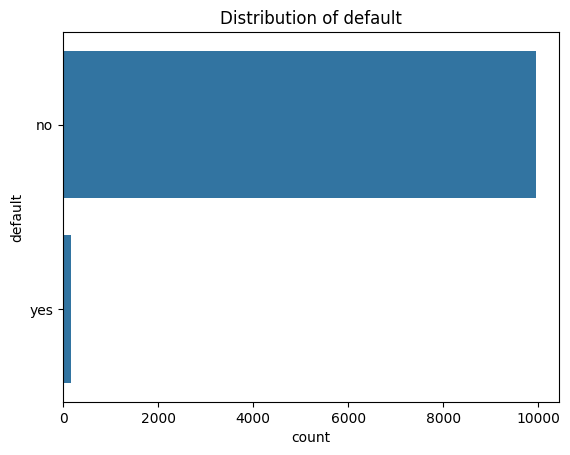

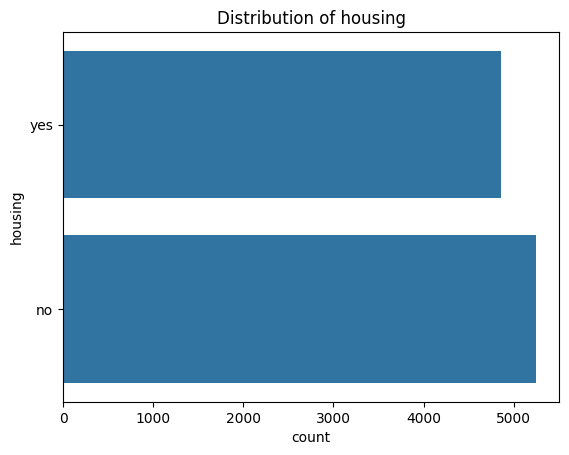

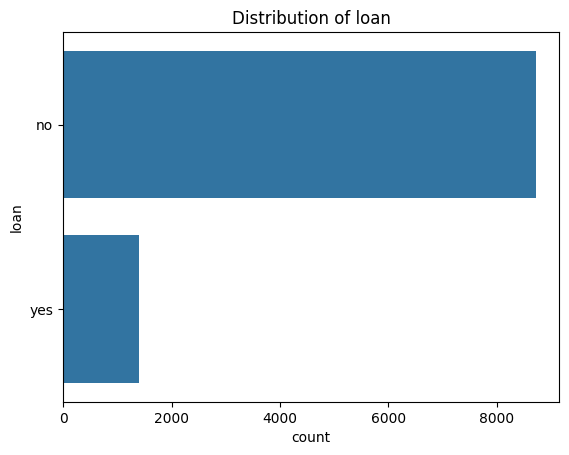

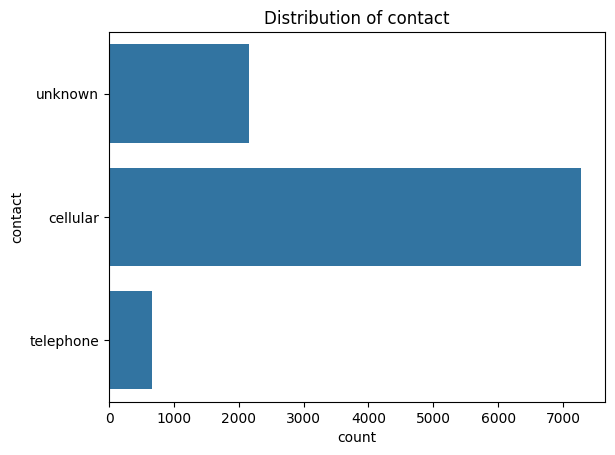

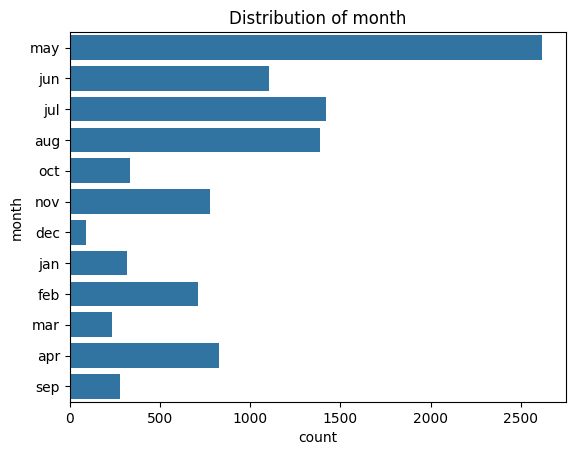

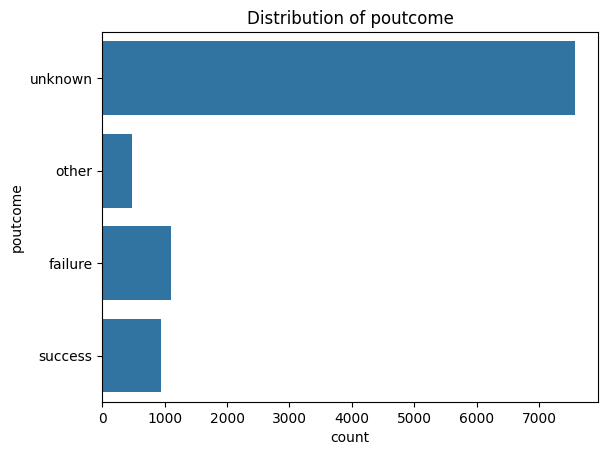

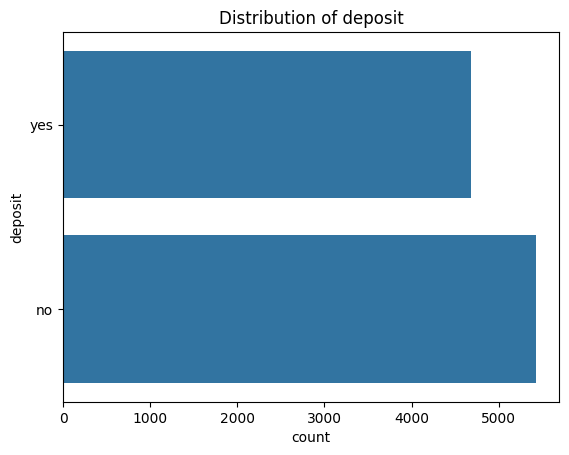

In [1767]:
# Выбираем только числовые колонки
cat_cols = df_cleaned.select_dtypes(include=['object']).columns

# Строим все гистограммы в цикле 
for col in cat_cols:
    sns.countplot(df_cleaned[col])
    plt.title(f'Distribution of {col}')
    plt.show()

**Вывод по графикам:** 

Посмотрим распределение месяцев в разрезе нашего целевого признака

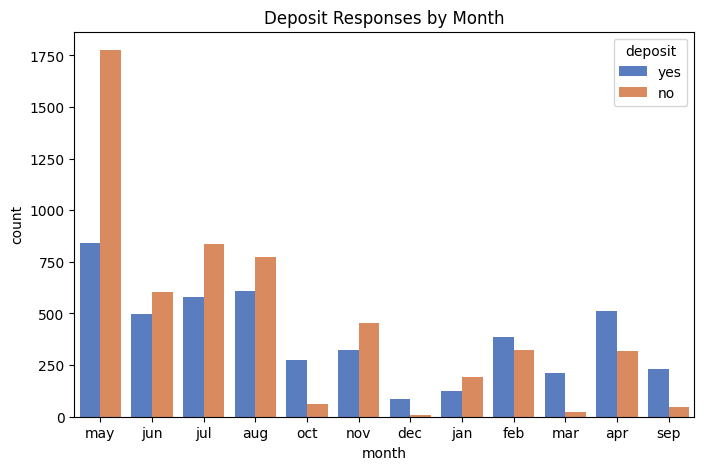

In [1768]:
# Создаем фигуру для графика
plt.figure(figsize=(8,5))
# Строим график
sns.countplot(data=df_cleaned, x='month', hue='deposit', palette='muted')
# Называем график
plt.title('Deposit Responses by Month')
plt.show()

**Вывод по графику:** Анализ признака month показал выраженную сезонность в откликах клиентов. В частности, в мае наблюдается наибольшее количество отказов: около 2/3 всех контактов заканчиваются ответом “нет”. В то же время в другие месяцы, такие как октябрь, декабрь, март и сентябрь, несмотря на меньший объём данных, доля положительных ответов заметно преобладает над отказами. Это может свидетельствовать о более благоприятном восприятии предложений в эти периоды.

Посмотрим на балансы аккаунтов в разрезе профессий

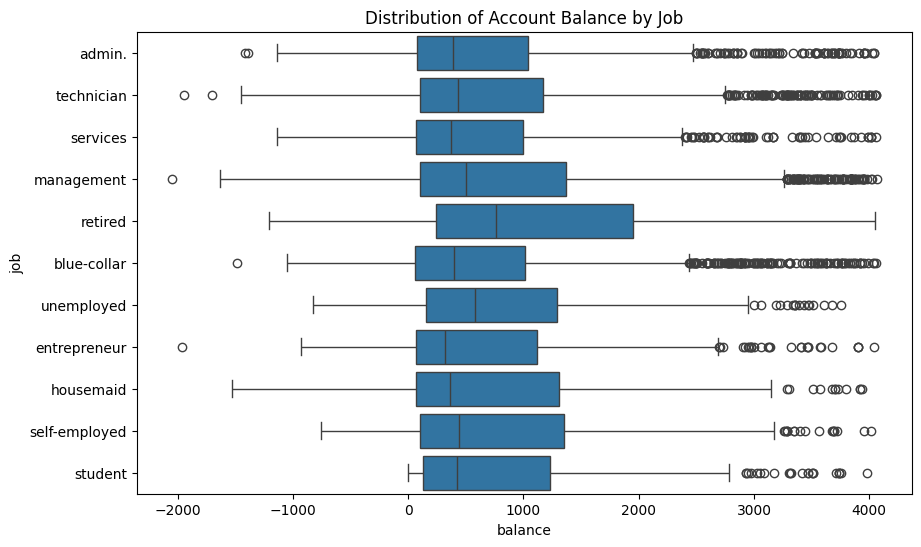

In [1769]:
# Создаем фигуру для графика
plt.figure(figsize=(10, 6))
# Строим боксплот
sns.boxplot(data=df_cleaned, x='balance', y='job')
# Называем график
plt.title('Distribution of Account Balance by Job')
plt.show()

**Вывод по графику:** На представленном графике видно, что наименьшее медианное значение баланса наблюдается у предпринимателей (около 300), при этом характерен значительный разброс значений — от 100 до 1200 (если рассматривать 50% данных). Наибольшее медианное значение — у клиентов, вышедших на пенсию (около 800), и разброс в этой категории ещё более выраженный: от 200 до 2000.

Интерес представляет также категория безработных: медианное значение составляет около 600, при этом наблюдается широкий разброс — от 100 до 1300.

Особое внимание стоит уделить студентам. Согласно предыдущему графику, соотношение клиентов, открывших депозит, более чем в два раза превышает тех, кто его не открыл. При этом уровень баланса у студентов практически не влияет на это решение.

Остальные профессии демонстрируют схожие медианные значения и длину коробки(межквартильные размахи), без значительных отклонений. Во всех категориях пристуствуют выбросы

### Задание 6

In [1770]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
poutcome_grouped = df_cleaned.groupby(['poutcome', 'deposit']).size().unstack()
poutcome_grouped

deposit,no,yes
poutcome,,
failure,562,547
other,216,265
success,84,861
unknown,4562,3008


<Axes: xlabel='poutcome'>

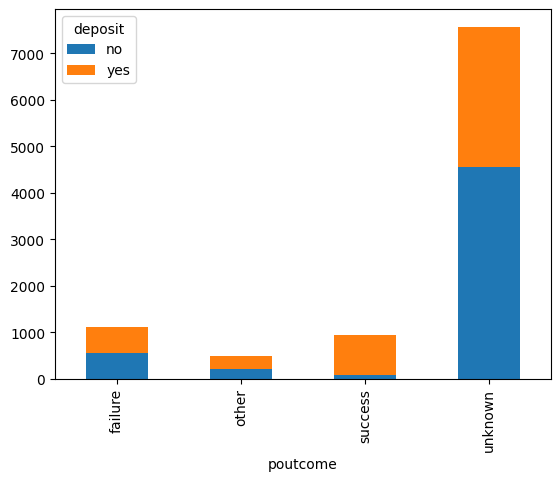

In [1771]:
poutcome_grouped.plot(kind='bar', stacked=True)

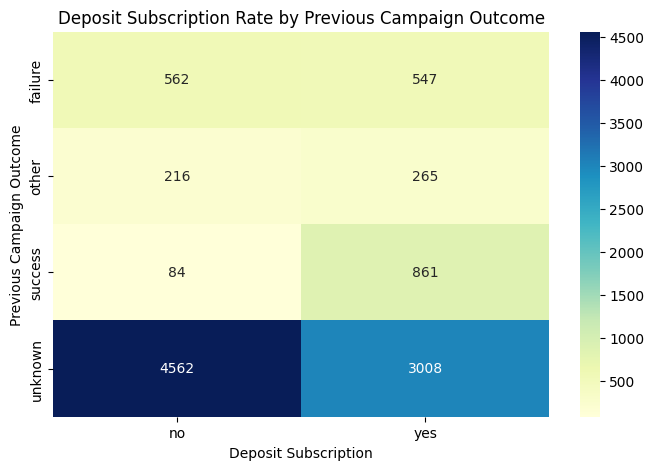

In [1772]:
# Создаем фигуру для графика 
plt.figure(figsize=(8, 5))
# Строим тепловую карту
sns.heatmap(poutcome_grouped, annot=True, fmt='d', cmap='YlGnBu')
# Добавляем заголовок графика
plt.title('Deposit Subscription Rate by Previous Campaign Outcome')
# Подписываем ось Y 
plt.ylabel('Previous Campaign Outcome')
# Подписываем ось X 
plt.xlabel('Deposit Subscription')
# Отображаем график
plt.show()

**Вывод по графику:** На тепловой карте четко видно, что клиенты, у которых прошлая маркетинговая кампания была успешной (success), демонстрируют значительно более высокий процент подписки на депозит в текущей кампании по сравнению с другими группами. Соотношение успеха в 10 раз больше чем неудач, что является крайне показательным результатом. Если рассматривать остальные группы, то там соотношение пплюс минус 50 на 50

### Задание 7

In [1773]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
# Считаем количество 'no' по месяцам
no_counts = df_cleaned[df_cleaned['deposit'] == 'no'].groupby('month').size().reset_index(name='no_count')
# Считаем количество 'yes' по месяцам
total_counts = df_cleaned.groupby('month').size().reset_index(name='total_count')
# Объединяем два датафрейма по колонке 'month'
month_combined = pd.merge(no_counts, total_counts, on='month', how='outer')
# Посчитаем столбец где самый большой процент неудач
month_combined['no_ratio'] = round((month_combined['no_count'] / month_combined['total_count']) * 100, 2)

month_combined.sort_values(by='no_ratio', ascending=False)

,month,no_count,total_count,no_ratio
8,may,1776,2617,67.86
4,jan,194,319,60.82
5,jul,836,1418,58.96
9,nov,456,780,58.46
1,aug,775,1385,55.96
6,jun,606,1104,54.89
3,feb,323,709,45.56
0,apr,317,830,38.19
10,oct,62,335,18.51
11,sep,46,278,16.55


68 процентов отказа было в мае месяце

### Задание 8

In [1774]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
# Создадим функцию, которая будет преобразовывать возраст(числовой тип) в возрастную индекатор(строковый тип)
# def get_age_group(age):
#     """
#     Функция определяет возрастную группу по заданному возрасту.

#     Аргументы:
#     age (int): Возраст человека.

#     Возвращает:
#     str: Строка с обозначением возрастной группы:
#         - '<30' — если возраст меньше 30 лет
#         - '30-40' — если возраст от 30 до 40 лет включительно
#         - '40-50' — если возраст от 40 до 50 лет включительно
#         - '50-60' — если возраст от 50 до 60 лет включительно
#         - '60+' — если возраст больше 60 лет
#     """
#     if age < 30:
#         return '<30'
#     elif 30 <= age <= 40:
#         return '30-40'
#     elif 40 <= age <= 50:
#         return '40-50'
#     elif 50 <= age <= 60:
#         return '50-60'
#     elif age > 60:
#         return '60+'
 
# # Применим нашу функцию к столбцу
# df_cleaned['age_group'] = df_cleaned['age'].apply(get_age_group)

df_cleaned['age_group'] = pd.cut(df_cleaned.age, [0,30,40,50,60,9999], labels = ['<30', '30-40', '40-50', '50-60', '60+'])
# Построим сводную табличку с возрастными группами и индикатором депозита
pivot_table_age = pd.crosstab(df_cleaned['age_group'], df_cleaned['deposit'])
# Создадим новый признак процент успеха
pivot_table_age['yes_ratio'] = round(pivot_table_age['yes'] / (pivot_table_age['yes'] + pivot_table_age['no']) * 100, 2)
print(pivot_table_age)

deposit      no   yes  yes_ratio
age_group                       
<30         819  1051      56.20
30-40      2215  1627      42.35
40-50      1360   895      39.69
50-60       933   692      42.58
60+          97   416      81.09


Построим диаграмму

In [1775]:
# Импортируем библиотку для визуализации
import plotly.express as px
# Построим столбчатую диаграмму
fig = px.bar(
    pivot_table_age.reset_index(),
    x='age_group',
    y='yes_ratio',
    title='Deposit Opening Rate by Age Group',
    width=1000
)
fig.show()

**Вывод по графику:** Наибольший процент открытий депозитов — в возрастной группе 60+ (81%). Далее идет группа <30 лет (59%). Остальные группы (30–40, 40–50, 50–60) имеют заметно меньшие показатели — около 40% каждая.

### Задания 9 и 10

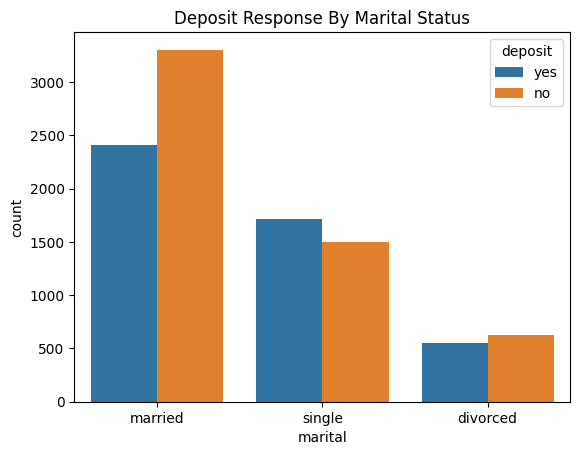

In [1776]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
# Построим диаграмму
sns.countplot(data=df_cleaned, x='marital', hue='deposit')
# Название диаграммы
plt.title('Deposit Response By Marital Status')
plt.show()

**Вывод по графику:** Самая популярная категория married(состоящие в браке), но она имеет отрицательную тенденцию, как и категория divorced(разведенные). Единственная категория, которая имеет положительную тенденцию - это single(одинокие)

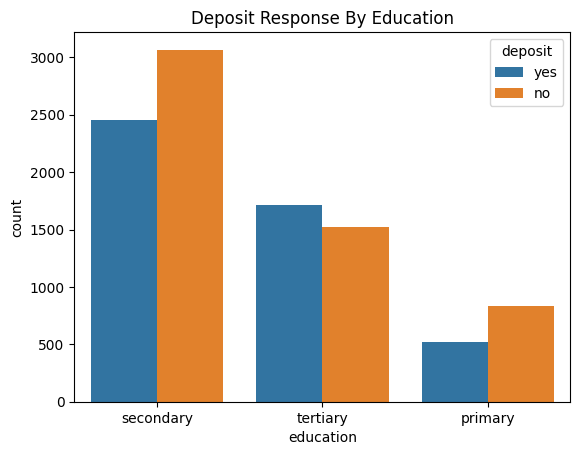

In [1777]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
# Построим диаграмму
sns.countplot(data=df_cleaned, x='education', hue='deposit')
# Название диаграммы
plt.title('Deposit Response By Education')
plt.show()

**Вывод по графику:** На графике видно, что уровень открытия депозитов увеличивается с ростом уровня образования. Клиенты с третичным уровнем образования имеют положительную тенденцию, в то время как другие категории отрицательную.

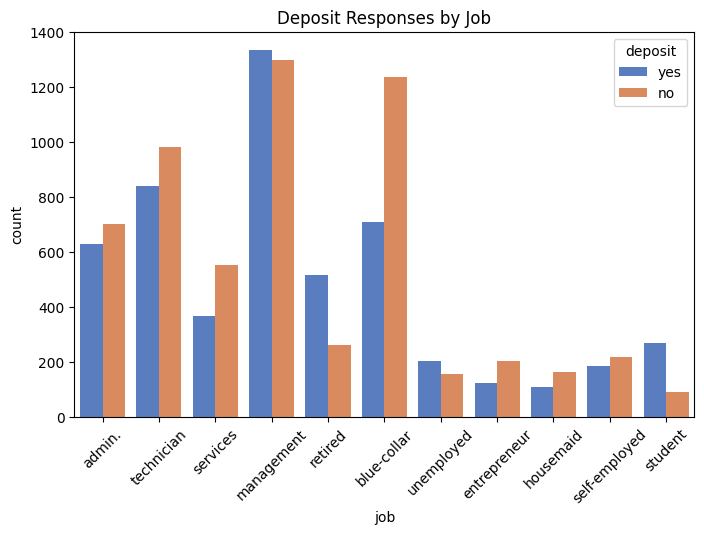

In [1778]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
# Создаем фигуру для графика
plt.figure(figsize=(8,5))
# Строим график
sns.countplot(data=df, x='job', hue='deposit', palette='muted')
# Называем графика
plt.title('Deposit Responses by Job')
# Поворачиваем надписи по оси Х под 45
plt.xticks(rotation=45)
# Показываем график
plt.show()

**Вывод по графику:** В целом, нет особой разницы в профессиях(в открытии депозита), в большинстве случаев это примерно равное соотношение. Но есть некоторые категории, которые привелкают внимание. Например Student(Студенты), казалось бы, не частая практика, но этому есть логичное объянение. У молодежи часто нет семьи, недвижимости за которую надо платить и так далее. И в основном за них платят родители. Вот отсюда и вытекает такая статистика. Также Retired(На пенсии) тоже показывает положительную тенденцию в разрезе нашего целевого признака. Тут я думаю тоже довольно легко объяснить. Накопил, положил на депозит. И есть еще так называемые рабочие, именно физическая работа(blue-collar). Тут наоборот 2/3 - это "нет". Связано это может быть с зарплатой или географической мобильностью, надо детальнее изучить данную категорию

### Задание 11

In [1779]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
# Фильтруем данные для тех, кто открыл депозит
df_filtered_yes = df_cleaned[df_cleaned['deposit'] == 'yes']  

# Строим сводную таблицу
pivot_table = pd.pivot_table(
    data=df_filtered_yes,
    index='education',         
    columns='marital',         
    values='deposit',          
    aggfunc='count'            
)

pivot_table

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


<Axes: xlabel='marital', ylabel='education'>

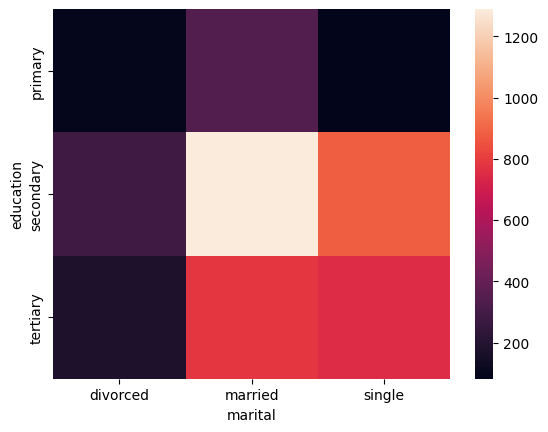

In [1780]:
sns.heatmap(pivot_table)

In [1781]:
# Фильтруем данные для тех, кто не открыл депозит
df_filtered_no = df_cleaned[df_cleaned['deposit'] == 'no'] 

# Строим сводную таблицу
pivot_table = pd.pivot_table(
    data=df_filtered_no,
    index='education',         
    columns='marital',         
    values='deposit',          
    aggfunc='count'            
)

pivot_table

marital,divorced,married,single
education,,,
primary,91,641,100
secondary,370,1830,866
tertiary,163,832,531


<Axes: xlabel='marital', ylabel='education'>

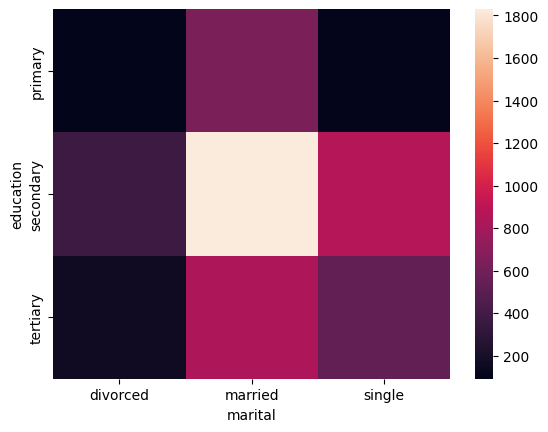

In [1782]:
sns.heatmap(pivot_table)

**Вывод по графику:** Самое популярное комбинация признаков marital и education - это married и secondary(1289 клиентов). Меньше всего клиентов с primary и single признаками

## Часть 3: преобразование данных

### Задание 1

In [1783]:
# преобразуйте уровни образования
# Инициализируем label encoder
le = LabelEncoder()
# Создадим новый преобразованный столбец
df_cleaned['education'] = le.fit_transform(df_cleaned['education'])

df_cleaned['education'].sum()

np.int64(11995)

In [1784]:
from sklearn.preprocessing import OrdinalEncoder


# # создаём энкодер, указывая порядок категорий
# ord_enc = OrdinalEncoder(categories=[['<30', '30-40', '40-50', '50-60', '60+']])

# # преобразуем столбец 'age_group' 
# df_cleaned['age_group'] = ord_enc.fit_transform(df_cleaned[['age_group']])

# # преобразуем столбец в int
# df_cleaned['age_group'] = df_cleaned['age_group'].astype(int)


le = LabelEncoder()
df_cleaned["age_group"] = le.fit_transform(df_cleaned["age_group"])

### Задания 2 и 3

In [1785]:
# преобразуйте бинарные переменные в представление из нулей и единиц
# Создадим функцию, которая будет преобразовывать yes в 1, а no в 0
def to_binary(row):
    """
    Преобразует строковое значение в бинарный формат.

    Если значение равно 'yes', возвращает 1.
    Для всех остальных значений возвращает 0.

    Параметры:
    row (str): Строка для проверки ('yes' или другое значение).

    Возвращает:
    int: 1, если row == 'yes', иначе 0.
    """
    
    if row == 'yes':
        return 1
    else:
        return 0

# Применим функцию to_binary к deposit
df_cleaned['deposit'] = df_cleaned['deposit'].apply(to_binary)
# Применим функцию to_binary к default
df_cleaned['default'] = df_cleaned['default'].apply(to_binary)
# Применим функцию to_binary к housing
df_cleaned['housing'] = df_cleaned['housing'].apply(to_binary)
# Применим функцию to_binary к loan
df_cleaned['loan'] = df_cleaned['loan'].apply(to_binary)

print(df_cleaned['deposit'].std())

0.4986712532452124


In [1786]:
# Среднее арифметическое для default
default_mean = df_cleaned['default'].mean()
# Среднее арифметическое для housing
housing_mean = df_cleaned['housing'].mean()
# Среднее арифметическое для loan
loan_mean = df_cleaned['loan'].mean()
# Суммируем результат
res = round(default_mean + housing_mean + loan_mean, 3)
print(res)

0.635


### Задание 4

In [1787]:
# создайте дамми-переменные
dummies = pd.get_dummies(df_cleaned, columns=['job', 'marital', 'contact', 'month', 'poutcome'])
dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int64  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_group          10105 non-null  int64  
 13  job_admin.         10105 non-null  bool   
 14  job_blue-collar    10105 non-null  bool   
 15  job_entrepreneur   10105 non-null  bool   
 16  job_housemaid      10105 no

### Задания 5 и 6

Text(0.5, 1.0, 'Correlation matrix')

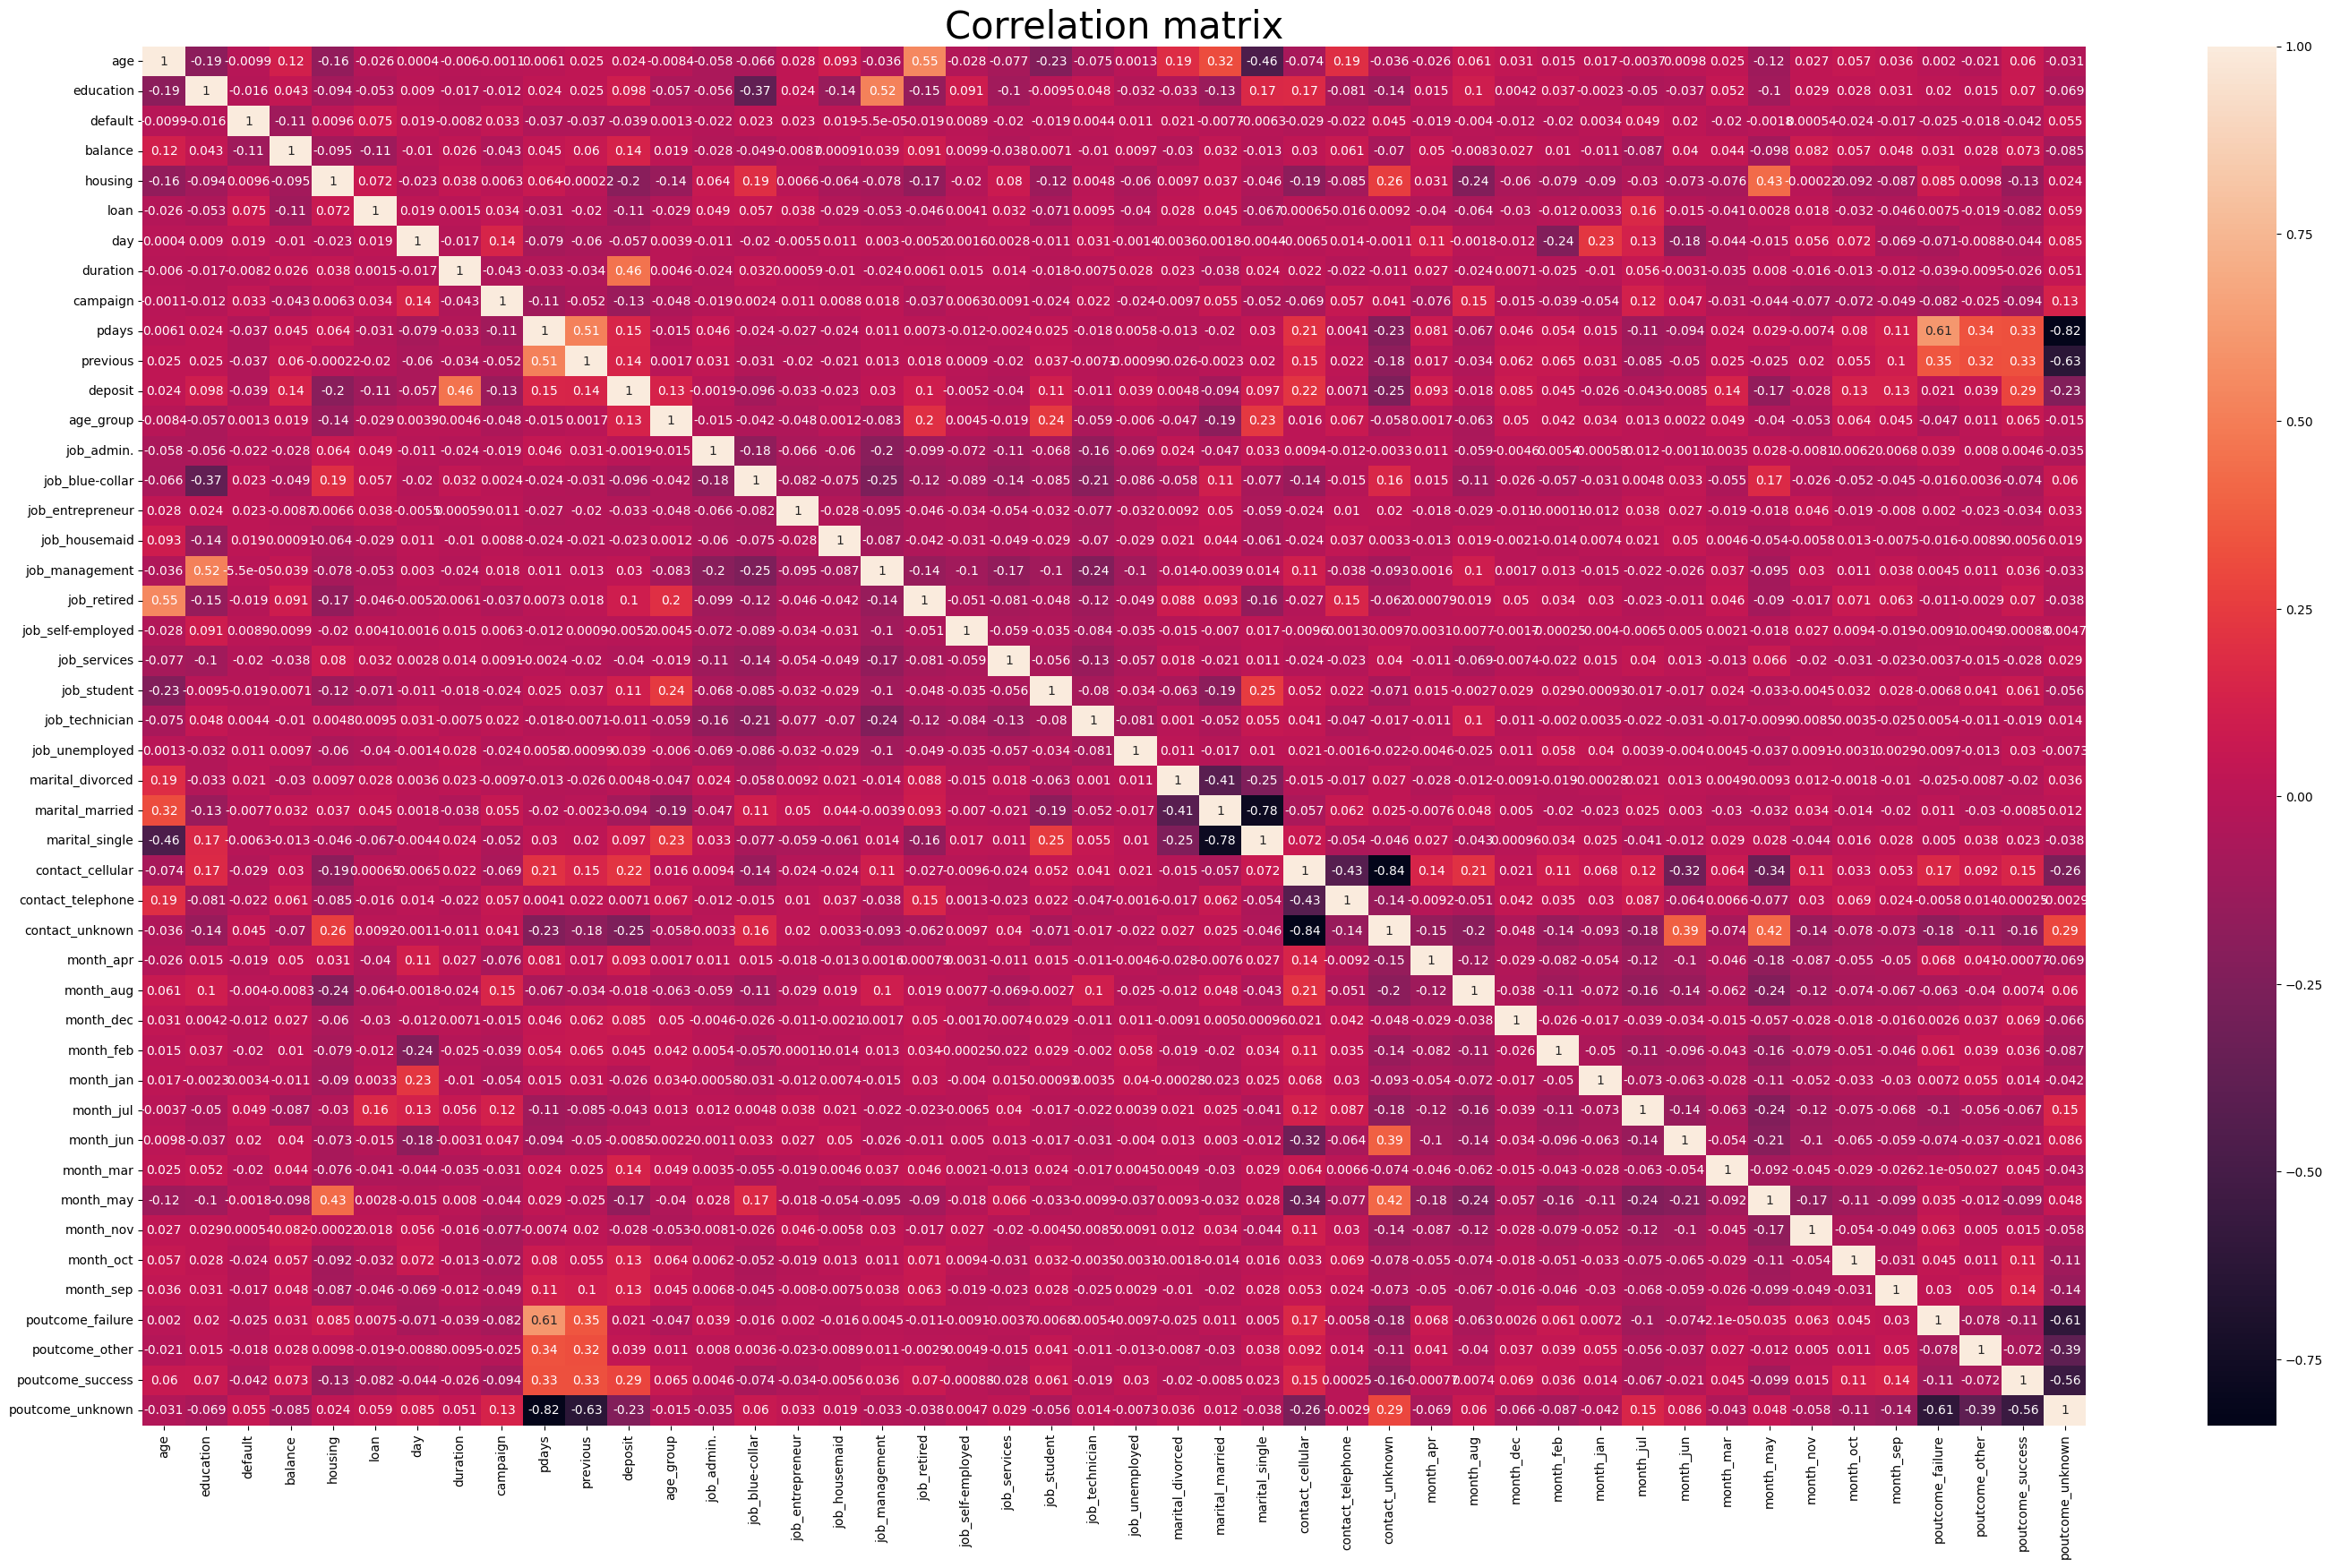

In [1788]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
# Считаем корреляцию признаков
corr_matrix = dummies.corr()

# Строим фигуру для тепловой карты
plt.figure(figsize=(35, 20))
# Строим тепловую карту
sns.heatmap(corr_matrix, annot=True)
# Название
plt.title('Correlation matrix', fontsize=30)

### Задания 7 и 8

In [1789]:
# Выделяем столбцы с bool типом 
bool_cols = dummies.select_dtypes(include='bool').columns
# Преобразуем bool в int
dummies[bool_cols] = dummies[bool_cols].astype(int)

In [1790]:
# Матрица наблюдений
X = dummies.drop(['deposit'], axis=1)
# Вектор ответов
y = dummies['deposit']
 
 # Делим данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
# Смотрим размерность тестовой выборки
X_test.shape

(3335, 45)

In [1791]:
# рассчитайте необходимые показатели
round(y_test.mean(), 2)

np.float64(0.46)

In [1792]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6770 entries, 7287 to 4966
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                6770 non-null   int64  
 1   education          6770 non-null   int64  
 2   default            6770 non-null   int64  
 3   balance            6770 non-null   float64
 4   housing            6770 non-null   int64  
 5   loan               6770 non-null   int64  
 6   day                6770 non-null   int64  
 7   duration           6770 non-null   int64  
 8   campaign           6770 non-null   int64  
 9   pdays              6770 non-null   int64  
 10  previous           6770 non-null   int64  
 11  age_group          6770 non-null   int64  
 12  job_admin.         6770 non-null   int64  
 13  job_blue-collar    6770 non-null   int64  
 14  job_entrepreneur   6770 non-null   int64  
 15  job_housemaid      6770 non-null   int64  
 16  job_management     6770 no

### Задание 9

In [1812]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
# инициализируем селектор
selector = SelectKBest(score_func=f_classif, k=15)  
# Обучим селектор на тестовой выборке
selector.fit(X_train, y_train)

# Запишем топ 15 признаков в переменную
imp_features_kbest = selector.get_feature_names_out()
print(imp_features_kbest)

# Используем выбранные признаки на тренировочной выборке
X_train_kbest = X_train[imp_features_kbest]
# Используем выбранные признаки на тестовой выборке
X_test_kbest = X_test[imp_features_kbest]

['balance' 'housing' 'duration' 'campaign' 'pdays' 'previous' 'age_group'
 'contact_cellular' 'contact_unknown' 'month_mar' 'month_may' 'month_oct'
 'month_sep' 'poutcome_success' 'poutcome_unknown']


### Задание 10

In [1816]:
# нормализуйте данные с помощью minmaxsxaler
# Инициализируем скалер
mm_scaler = MinMaxScaler()
# Обучаем скалер 
mm_scaler.fit(X_train_kbest)
# Преобразуем тренировочные данные
X_train_scaled = mm_scaler.transform(X_train_kbest)
# Преобразуем тестовые данные
X_test_scaled = mm_scaler.transform(X_test_kbest)

print(round(X_test_scaled[:, 0].mean(), 2))

0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [1821]:
# обучите логистическую регрессию и рассчитайте метрики качества
# Инициализируем объект логистической регрессии
log_reg = LogisticRegression(solver='sag', max_iter=1000 , random_state=42)
# Обучим модель на тренировочном наборе данных
log_reg.fit(X_train_scaled, y_train)
# Сделаем предсказания на тестовом наборе данных
y_test_pred = log_reg.predict(X_test_scaled)
# Посчитаем метрику accuracy
print(f'Метрика accuracy на тестовом наборе данных: {metrics.accuracy_score(y_test, y_test_pred):.2f}')

Метрика accuracy на тестовом наборе данных: 0.81


### Задания 2,3,4

In [1825]:
# обучите решающие деревья, настройте максимальную глубину
# Инициализируем объект дерева решений
dt = DecisionTreeClassifier(criterion='entropy', random_state=42)
# Обучим модель на тренировочных данных
dt.fit(X_train_scaled, y_train)
# Предскажем значения для тренировочной выборки
y_train_pred = dt.predict(X_train_scaled)
# Предскажем значения для тестовой выборки
y_test_pred = dt.predict(X_test_scaled)

# Рассчитаем метрику accuracy для тренировочных данных
print(f'Метрика accuracy на тренировочном наборе данных: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
# Рассчитаем метрику accuracy для тестовых данных
print(f'Метрика accuracy на тестовом наборе данных: {metrics.accuracy_score(y_test, y_test_pred):.2f}')

Метрика accuracy на тренировочном наборе данных: 1.00
Метрика accuracy на тестовом наборе данных: 0.75


In [1829]:
# Инициализируем объект дерева решений
dt = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=6)
# Обучим модель на тренировочных данных
dt.fit(X_train_scaled, y_train)
# Предскажем значения для тренировочной выборки
y_train_pred = dt.predict(X_train_scaled)
# Предскажем значения для тестовой выборки
y_test_pred = dt.predict(X_test_scaled)

# Рассчитаем метрику accuracy на тренировочном наборе данных
print(f'Метрика accuracy на тренировочном наборе данных: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
# Рассчитаем метрику accuracy на тестовом наборе данных
print(f'Метрика accuracy на тестовом наборе данных: {metrics.accuracy_score(y_test, y_test_pred):.2f}')

Метрика accuracy на тренировочном наборе данных: 0.82
Метрика accuracy на тестовом наборе данных: 0.81


### Задание 5

In [1833]:
# подберите оптимальные параметры с помощью gridsearch
# Зададим сетку параметров
param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth': [3,5,7]
              }
# Инициализируем объект grid_search
grid_search_tree = GridSearchCV(
    param_grid=param_grid,
    cv=5,
    estimator=tree.DecisionTreeClassifier(random_state=42),
    n_jobs=-1
)
# Обучим модель и найдем оптимальные гиперпараметры
grid_search_tree.fit(X_train_scaled, y_train)
# Предскажем значения для тестовой выборки
y_test_pred = grid_search_tree.predict(X_test_scaled)
# Рассчитаем метрику f1_score на тестовом наборе данных
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}


In [1828]:
grid_search_tree.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=np.int64(8),
                       min_samples_leaf=np.int64(3), random_state=42)

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [1842]:
# обучите на ваших данных случайный лес
rf = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_leaf=5, max_depth=10, random_state=42)
# Обучим модель на тренировочном наборе данных
rf.fit(X_train_scaled, y_train)
# Предскажем значения для тестового набора данных
y_test_pred = rf.predict(X_test_scaled)
# Посчитаем метрику accuracy для тестового набора данных
print(f'Метрика accuracy на тестовом наборе данных: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
# Почтимаем метрику recall для тестового набора данных
print(f'Метрика recall на тестовом наборе данных: {metrics.recall_score(y_test, y_test_pred):.2f}')
# Рассчитаем метрику f1_score на тестовом наборе данных
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Метрика accuracy на тестовом наборе данных: 0.83
Метрика recall на тестовом наборе данных: 0.83
f1_score на тестовом наборе: 0.82


### Задания 2 и 3

In [1849]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = GradientBoostingClassifier(learning_rate = 0.05, n_estimators = 300, min_samples_leaf = 5, max_depth = 5, random_state = 42)
# Обучим модель на тренировочном наборе данных
gb.fit(X_train_scaled, y_train)
# Предскажем значения для тестового набора данных
y_test_pred = gb.predict(X_test_scaled)
# Посчитаем метрику accuracy для тестового набора данных
print(f'Метрика accuracy на тестовом наборе данных: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
# Почтимаем метрику recall для тестового набора данных
print(f'Метрика recall на тестовом наборе данных: {metrics.recall_score(y_test, y_test_pred):.2f}')
# Рассчитаем метрику f1_score на тестовом наборе данных
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Метрика accuracy на тестовом наборе данных: 0.83
Метрика recall на тестовом наборе данных: 0.83
f1_score на тестовом наборе: 0.82


### Задание 4

In [1845]:
# объедините уже известные вам алгоритмы с помощью стекинга 
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('dt', DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=6)),
    ('log_reg', LogisticRegression(solver='sag', max_iter=1000 , random_state=42)),
    ('gb', GradientBoostingClassifier(learning_rate = 0.05, n_estimators = 300, min_samples_leaf = 5, max_depth = 5, random_state = 42))
]
# Создаем объект класса стекинг
stacking = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=42)
)
# Обучим модель на тренировочном наборе данных
stacking.fit(X_train_scaled, y_train)
# Предскажем значения для тестового набора данных
y_test_pred = stacking.predict(X_test_scaled)
# Посчитаем метрику precision для тестового набора данных
print(f'Метрика precision на тестовом наборе данных: {metrics.precision_score(y_test, y_test_pred):.2f}')

Метрика precision на тестовом наборе данных: 0.81


### Задание 5

<Axes: xlabel='feauture', ylabel='importances'>

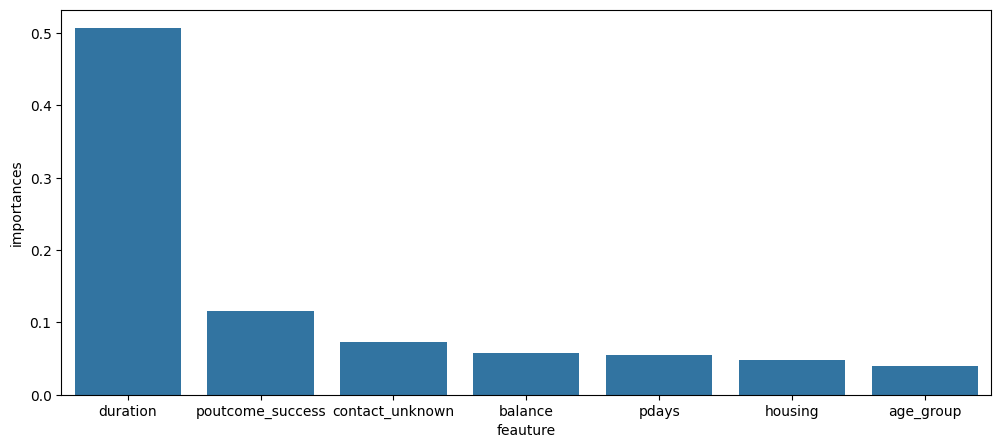

In [1867]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
feauture_names = X_train_kbest.columns
importances = gb.feature_importances_
feature_importances_df = pd.DataFrame({
    'feauture': feauture_names,
    'importances': importances
}).sort_values(by='importances', ascending=False)

plt.figure(figsize=(12, 5))
sns.barplot(data=feature_importances_df[:7], x='feauture', y='importances')

Топ 3 признака: duration, poutcome_success, contact_unknown

### Задания 6,7,8

In [1871]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    # Создаем модель
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    # Обучаем модель
    model.fit(X_train_scaled, y_train)
    # Считаем метрику
    score=metrics.f1_score(y_train, model.predict(X_train_scaled))
    
    return score

# Создаем эксперимент    
study = optuna.create_study(direction='maximize', study_name='RandomForestClassifier')
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

[I 2025-05-01 16:35:26,644] A new study created in memory with name: RandomForestClassifier
[I 2025-05-01 16:35:27,232] Trial 0 finished with value: 0.8465641669281456 and parameters: {'n_estimators': 193, 'max_depth': 19, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8465641669281456.
[I 2025-05-01 16:35:27,760] Trial 1 finished with value: 0.8611544461778471 and parameters: {'n_estimators': 169, 'max_depth': 29, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8611544461778471.
[I 2025-05-01 16:35:28,109] Trial 2 finished with value: 0.8509773260359657 and parameters: {'n_estimators': 126, 'max_depth': 21, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8611544461778471.
[I 2025-05-01 16:35:28,686] Trial 3 finished with value: 0.8902840998273427 and parameters: {'n_estimators': 174, 'max_depth': 14, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8902840998273427.
[I 2025-05-01 16:35:28,980] Trial 4 finished with value: 0.8485421591804571 and parameters: {'n

Наилучшие значения гиперпараметров {'n_estimators': 183, 'max_depth': 23, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92


In [1877]:
rf = ensemble.RandomForestClassifier(**study.best_params, random_state=42)
rf.fit(X_train_scaled, y_train)
y_test_pred = rf.predict(X_test_scaled)
y_train_pred = rf.predict(X_train_scaled)
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(metrics.accuracy_score(y_test, y_test_pred)))

f1_score на тренировочном наборе: 0.92
f1_score на тестовом наборе: 0.82
accuracy на тестовом наборе: 0.83
